# Figure 5 - UMAP Step-by-step

This notebook was used to generate Figure 5, which explains how the UMAP method works.

For this work, we rely on UMAPs implementation available in the umap-learn library (https://umap-learn.readthedocs.io/en/latest/).

For this demonstration we will use the tvFC from one run of the multi-task dataset previously published in [Gonzalez-Castillo et al. PNAS (2015)](https://www.pnas.org/doi/abs/10.1073/pnas.1501242112)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import Bunch, check_random_state
from utils.basics import task_cmap_caps as cmap
import umap
import umap.plot
from utils.plotting import plot_matrix, plot_matrix_as_graph, check_symmetric
import hvplot.pandas
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
import hvplot.networkx as hvnx
import panel as pn
from IPython.display import Image
from sklearn.metrics import pairwise_distances
import umap.distances as dist
import tqdm

***

# Configuration Variables

In [2]:
knn               = 90                                       # Number of neighbors
m_dist            = 0.8                                      # Minimum distance in lower dimensional space
d                 = 'euclidean'                              # Distance function
alpha_init        = 0.01                                     # Initial Learning Rate for the Stochastic Gradident Descent Phase
umap_metric_func  = dist.named_distances[d]                  # Rapid implementation of the distance function
random_state_seed = 20                                       # Random seed to ensure repeatibility of results
random_state      = check_random_state(random_state_seed)    # Random numpy object (using the above seed)

***
# Load a representative tvFC dataset

First, we will load the same representative tvFC dataset used in the previous three notebooks.

In [3]:
print('++ INFO: Loading the tvFC dataset.....')
X_df = pd.read_csv('../Resources/Figure03/swcZ_sbj06_ctask001_nroi0200_wl030_ws001.csv.gz', index_col=[0,1])

# Becuase pandas does not like duplicate column names, it automatically adds .1, .2, etc to the names. We delete those next
X_df.columns = X_df.columns.str.split('.').str[0]
# Extract Task Lbaels (for coloring purposes)
labels             = pd.Series(X_df.columns)
X                  = X_df.values.T
X[X==0]            = 1e-12
X_orig             = X.copy()
(n_wins, n_conns)  = X.shape         # n = number of samples | d = original number of dimensions
print(' +       Input data shape = [%d Windows X %d Connections]' % (n_wins, n_conns))

++ INFO: Loading the tvFC dataset.....
 +       Input data shape = [988 Windows X 12246 Connections]


We put together the data and the labels in a sklearn.Bunch object for organizational purposes

In [4]:
# Convert to a sklearn.Bunch object
tvFC        = Bunch()
tvFC.data   = X.astype(np.float32)
tvFC.labels = labels

To annotate affinity and dissimilarity matrixes, we will next extract:
* The location of transitions between tasks: ```line_idxs```
* The center window of each homogenous task period: ```tick_idxs```

The transitions will be used to draw dashed lines and the centers for placement of labels on the axes.

In [5]:
aux       = labels[(labels != labels.shift(1))] # Check for discontinuities in label names.
line_idxs   = aux.index.values  # Indexes to windows where task changes (e.g., REST -> XXXX, BACK --> VIDEO)
tick_idxs   = aux.index + np.diff(list(aux.index) + [n_wins])/2 # Midpoint for each task block (in terms of windows)
tick_labels = aux.values
print('++ INFO: Number of Tick Labels = %d | %s' % (len(tick_labels),str(tick_labels)))

++ INFO: Number of Tick Labels = 16 | ['REST' 'XXXX' 'BACK' 'XXXX' 'VIDE' 'XXXX' 'MATH' 'XXXX' 'BACK' 'XXXX'
 'REST' 'XXXX' 'MATH' 'XXXX' 'VIDE' 'XXXX']


Finally, we also extract a list of unique labels

In [6]:
# Obtain a list of unique labels, so that we can plot nodes corresponding to each task one-by-one with differnet colors
unique_win_labels = tvFC.labels.unique()
unique_win_labels.sort()
unique_win_labels

array(['BACK', 'MATH', 'REST', 'VIDE', 'XXXX'], dtype=object)

***
# 1. UMAP in a single call

First, we compute the final embedding using UMAP's ```fit()``` function over the tvFC data. 

This will run the UMAP algorithm completely and return the final embedding in two dimensions. To accomplish this task, as a minium, the user must provide:

* A distance function (d)
* The number of neighbors (knn)
* Minimum inter-sample distance in the embedded space. 

For the rest of hyper-parameters, UMAP will run with default values.

Although the purpose of this notebook is to break the UMAP algorithm into its main components, we do a full run of UMAP first for the following two reasons:

* So we can compare to the output generated later on the notebook when we decompose the UMAP algorithm into its basic steps.
* To access the many additional hyper-parameters for which we will be using default values.

In [86]:
mapper = umap.UMAP(n_neighbors=knn, 
                   min_dist=m_dist, 
                   metric=d, 
                   random_state=random_state, 
                   verbose=True,
                   learning_rate=alpha_init).fit(tvFC.data)

UMAP(learning_rate=0.01, min_dist=0.8, n_neighbors=90, random_state=RandomState(MT19937) at 0x2AABECEBE7C0, verbose=True)
Thu Sep  8 17:40:27 2022 Construct fuzzy simplicial set
Thu Sep  8 17:40:32 2022 Finding Nearest Neighbors
Thu Sep  8 17:40:32 2022 Finished Nearest Neighbor Search
Thu Sep  8 17:40:32 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Sep  8 17:40:36 2022 Finished embedding


For plotting purposes, let's convert the output of mapper into a ```pandas.Dataframe```.

> NOTE: The umap library provides plotting tools to easily visualize UMAP outputs. You may want to explore those.

In [87]:
embedding_df = pd.DataFrame.from_dict(mapper.embedding_)
embedding_df.columns = ['x','y']
embedding_df.index.name = 'Windows'
embedding_df['Task'] = tvFC.labels
ref_umap_2demb = embedding_df.hvplot.scatter(x='x',y='y', aspect='square', cmap=cmap, color='Task', 
                            xlabel='', ylabel='', size=5, legend='top', frame_width=400, fontsize={'labels':14,'ticks':14,'legend':14}).opts(toolbar=None, xticks=[(-100,'')],yticks=[(-100,'')])
pn.pane.HoloViews(ref_umap_2demb).save('../Resources/Figure05/ref_umap_2demb.png')

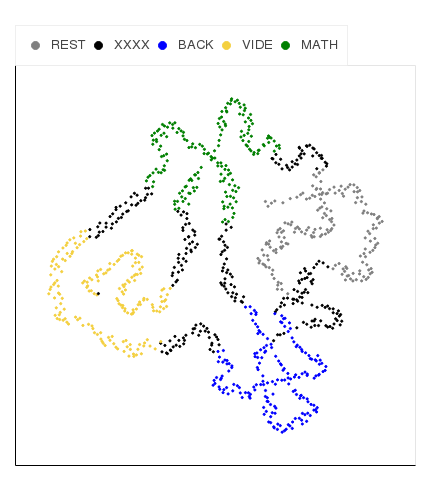

In [88]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add ref_umap_2demb to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure05/ref_umap_2demb.png")

***
# 2. Decompose UMAP into its main algorithmic steps

For explanatory purpose, we will now run the basic UMAP algorithm on the same data, but deconstructing it into its main steps, namely:

1. Computation of dissimilarity matrix
2. Computation of affinity matrix with neighboring relationships
3. Computation of the normalized version of the affinity matrix using equations 7 through 9 of the manuscript
4. Symmetrize the normalized neighboring graph
5. Estimation of optimal layout in 2D space

***
## PHASE 1 - Graph Generation 
### 2.1 Phase 1.a - Compute Dissimilarity Matrix

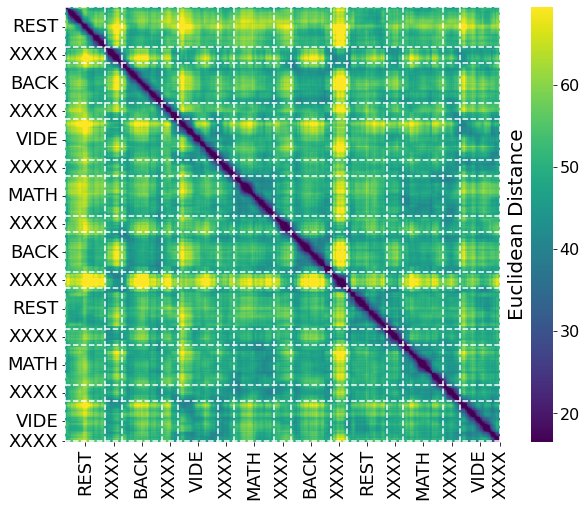

In [13]:
DS = pairwise_distances(tvFC.data,metric=umap_metric_func)
plot_matrix(DS, tick_idxs=tick_idxs, tick_labels=tick_labels, line_idxs=line_idxs)

### 2.2. Phase 1.b - Compute Affinity Matrix

For this we rely on umap function ```nearest_neighbors```, which returns:

* ```knn_indices```: indices for the neighbors of each data point.
* ```knn_dists```: distances for the neighbors of each data point.

> NOTE: ```nearest_neighbors``` internally computes again DS based on the data and the distance metric. We pre-computed it above for explanatory purposes only.

In [14]:
knn_indices, knn_dists, _ = umap.umap_.nearest_neighbors(tvFC.data, 
                                                         n_neighbors=knn,
                                                         random_state=random_state,
                                                         n_jobs=-1,
                                                         metric=umap_metric_func, metric_kwds={}, angular=False)

We can re-create a full version of the A matrix using ```knn_indices``` and ```knn_dists``` as follows:

In [15]:
A = np.zeros((n_wins,n_wins))
for w in range(n_wins):
    A[w,knn_indices[w]] = 1

Next, we check that A construced this way is not a symmetric matrix.

In [16]:
check_symmetric(A)

False

We also check that row-wise sums across A equals the number of desired neighbors (knn)

In [17]:
# The row-wise sum is always 90, as every node has 90 neighbours, incluging itself
print(A.sum(axis=1))

[90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90

Let's look at A as a binary matrix and its equivalent directed graph

In [18]:
A_matrix_plot = plot_matrix(A,cmap=colors.ListedColormap(['white', 'black']),
            tick_idxs=tick_idxs, tick_labels=tick_labels, line_idxs=line_idxs,net_separators='k--', 
            ctitle='Edge Weight', cticks=[0.25,0.75], clabels=['0', '1'])
A_graph_plot = plot_matrix_as_graph(A, node_labels=tvFC.labels, node_cmap=cmap, layout='spectral', verbose=True, width=500, height=500).opts(toolbar=None)

++ INFO[plot_matrix_as_graph]: Input Matrix Symmetric? False
++ INFO[plot_matrix_as_graph]: Graph Object created [type=<class 'networkx.classes.digraph.DiGraph'>]
++ INFO[plot_matrix_as_graph]: Graph positions computed
++ INFO[plot_matrix_as_graph]: Plotting the edges.... [DONE]
++ INFO[plot_matrix_as_graph]: Plotting the nodes.... [DONE]


In [19]:
A_view = pn.Row(A_matrix_plot,A_graph_plot)

In [20]:
%%time 
A_view.save('../Resources/Figure05/A_matrix_and_graph.png')

CPU times: user 2min 56s, sys: 851 ms, total: 2min 57s
Wall time: 3min 2s


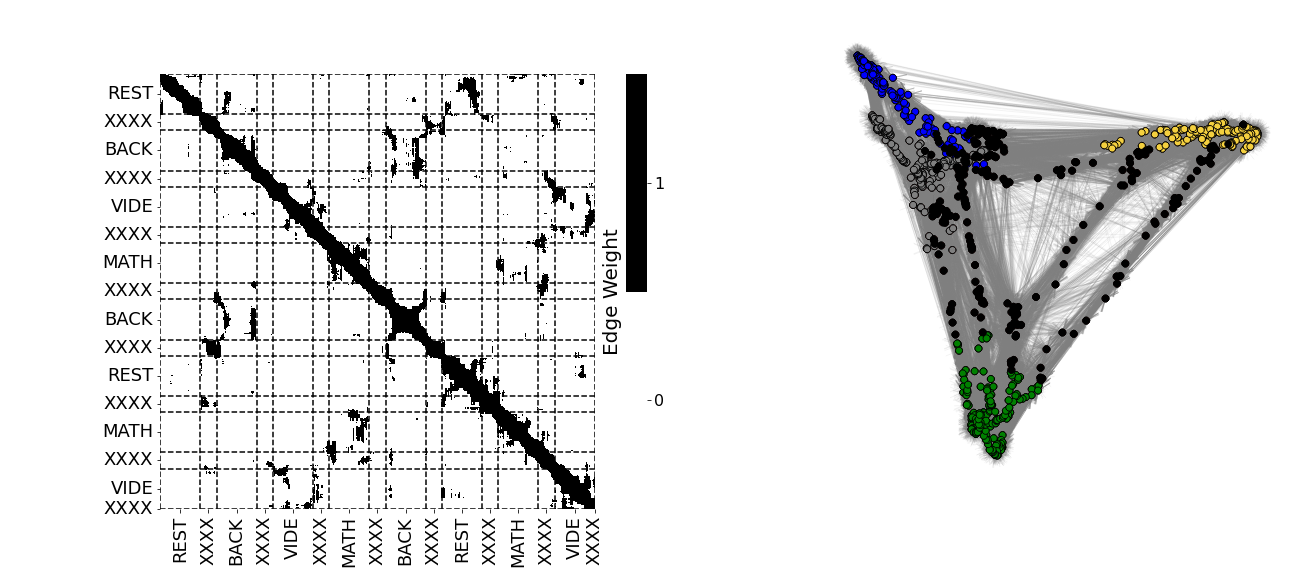

In [21]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add A_view to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure05/A_matrix_and_graph.png")

### 2.2. Phase 1.c - Normalize Dissimilarities

UMAP constructs a graph for the data in a way that ensures that the data looks uniformly distributed over the original manifold. To accomplish this, UMAP defines dissimilarity differently on each data sample by normalizing the original dissimilarities using equations 7 - 9 of the manuscript.

Here, we first use UMAP function ```fuzzy_simplicial_set``` to compute node-wise values for sigma and rho (Equations 8 and 9)

In [22]:
G, sigmas, rhos = umap.umap_.fuzzy_simplicial_set(DS,
                                                  n_neighbors=knn,
                                                  random_state=random_state,
                                                  metric="precomputed")

Next, we compute the normalized distances between neighbors using Equation 7

In [23]:
B = np.zeros((n_wins,n_wins))
for i in range(n_wins):
    for jj,j in enumerate(knn_indices[i]):
        B[i,j] = np.exp(-np.max([0,knn_dists[i,jj]-rhos[i]])/sigmas[i])

We now create a ```pd.DataFrame``` object that has one row per neighboring relationship and three columns:
* k_index: edge index
* DS: dissimilarity as originally computed 
* w: dissimilarity following the normalization step

This will allow us to graphically inspect the effect of this normalization step on the distances

In [24]:
%%time
Normatilized_Weights = pd.DataFrame(columns=['k_index','DS','w'])
for i in range(n_wins):
    for jj,j in enumerate(knn_indices[i]):
        aux_k = jj
        aux_w = B[i,j]
        aux_ds = knn_dists[i,jj]
        Normatilized_Weights = Normatilized_Weights.append({'k_index':aux_k,'DS':aux_ds,'w':aux_w}, ignore_index=True)

CPU times: user 1min 28s, sys: 13.5 ms, total: 1min 28s
Wall time: 1min 28s


We know create a scatter plot with one point per edge in which: 

* the X-axis will show the original dissimiality, and
* the Y-axis its normalized version. 

We can observe how the normalization step brings all neighbodring distances to the range [0,1] and how it has that effect of making the data look uniformly distributed over the manifold in the original ambient space

In [54]:
nw_plot = Normatilized_Weights.hvplot.scatter(x='DS',y='w', datashade=True, fontsize={'labels':18,'ticks':18}, xlabel='Original Distance',ylabel='Normalized Dist.')
pn.pane.HoloViews(nw_plot).save('../Resources/Figure05/normalized_weights.png')

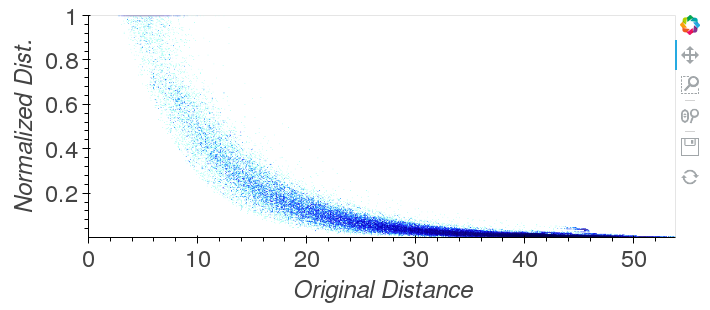

In [55]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add nw_plot to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure05/normalized_weights.png")

Similarly to $G_a$, $G_b$ is still defined by a non-symmetric matrix, meaning $G_b$ is still a directed graph. 

We can see this new graphical representation of the data using an spectral layout

In [57]:
check_symmetric(B)

False

In [58]:
B_graph_plot = plot_matrix_as_graph(B, node_labels=tvFC.labels, node_cmap=cmap, layout='spectral', verbose=True, width=500, height=500).opts(toolbar=None)

++ INFO[plot_matrix_as_graph]: Input Matrix Symmetric? False
++ INFO[plot_matrix_as_graph]: Graph Object created [type=<class 'networkx.classes.digraph.DiGraph'>]
++ INFO[plot_matrix_as_graph]: Graph positions computed
++ INFO[plot_matrix_as_graph]: Plotting the edges.... [DONE]
++ INFO[plot_matrix_as_graph]: Plotting the nodes.... [DONE]


In [59]:
%%time
pn.pane.HoloViews(B_graph_plot).save('../Resources/Figure05/B_graph_plot_colored.png')

CPU times: user 2min 55s, sys: 734 ms, total: 2min 56s
Wall time: 3min 2s


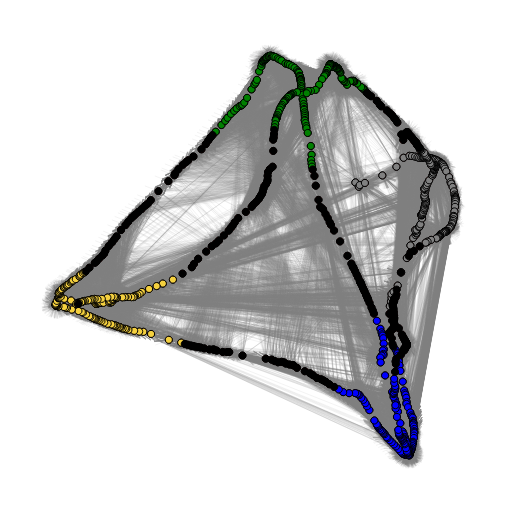

In [60]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add B_graph_plot to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure05/B_graph_plot_colored.png")

### 2.2. Phase 1.c - Convert to Undirected Graph

Once $B$ (namely the affiinity matrix that defines $G_b$) is available, we can rely on equation 10 to create the directed graph $G_c$ (defined by matrix $C$)

In [61]:
C = B + np.transpose(B)-(np.multiply(B,np.transpose(B)))
np.fill_diagonal(C,0)

This matrix $C$ is the adjancency matrix associated with $G_c$, which is the final undirected graph representing the data. 

> NOTE: This is the same graph provided by ```fuzzy_simplicial_set```, and normaly one would not go through all these steps separately. In fact for the rest of the notebook we will use that ouput (variable G)

We can also check the symmetry

In [64]:
check_symmetric(C)

True

Finally, we can plot G as an undirected graph using an spectral layout (which is sets the initialization of the optimization problem to be solved in phase 2)

In [65]:
G_plot = plot_matrix_as_graph(G.todense(), node_labels=tvFC.labels, node_cmap=cmap)

In [66]:
%%time
pn.pane.HoloViews(G_plot).save('../Resources/Figure05/G_graph_plot_colored.png')

CPU times: user 856 ms, sys: 39.2 ms, total: 895 ms
Wall time: 5.18 s


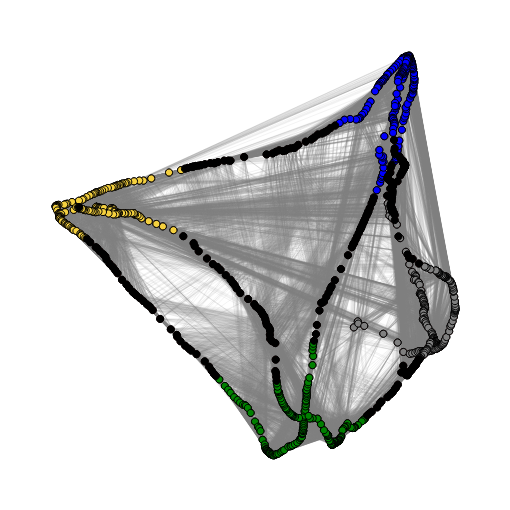

In [67]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add G_graph_plot_colored.png to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure05/G_graph_plot_colored.png")

***
## PHASE 2 - Layout Optimization

Once $G_c$ is available, the low dimensional represention of the data is obtained by optimizing the layout of the graph nodes in 2D space. 

For this, UMAP relies on a gradient descent algorithm that attempts to minimize the edge-wise cross-entropy between $G_c$ and an equivalent graph $H$ whose layout is determined by a set of attractive forces along the edges and repulsive forces between the nodes.

The function that performs this last step is ```simplicial_set_embedding```. 

We first run this function with n_epochs = 500 and all other hyper-parameters set to the same default values that we selected in our original call to UMAP.fit(). We do this to ensure that the final embedding generated here is equivalent to the original one obtained the single call to UMAP.fit()

In [69]:
E = umap.umap_.simplicial_set_embedding(data = tvFC.data.astype(np.float32), 
                                    graph = G, 
                                    n_components = 2,
                                    initial_alpha = alpha_init, 
                                    a = mapper._a,
                                    b = mapper._b,
                                    gamma = mapper.repulsion_strength,
                                    negative_sample_rate = mapper.negative_sample_rate,
                                    n_epochs = 500,
                                    init = 'spectral',
                                    random_state=check_random_state(20),
                                    metric=umap_metric_func,
                                    metric_kwds={},
                                    densmap = False,
                                    densmap_kwds= {'lambda': 0.0, 'frac': 0.0, 'var_shift': 0.1, 'n_neighbors': 90},
                                    output_dens=False,
                                    verbose=True,
                                    output_metric=umap_metric_func,
                                    output_metric_kwds={})

  0%|          | 0/500 [00:00<?, ?it/s]

In [70]:
embedding_df = pd.DataFrame.from_dict(E[0])
embedding_df.columns = ['x','y']
embedding_df.index.name = 'Windows'
embedding_df['Task'] = tvFC.labels
embedding_df.hvplot.scatter(x='x',y='y', aspect='square', cmap=cmap, color='Task')
embedding_plot = embedding_df.hvplot.scatter(x='x',y='y', aspect='square', cmap=cmap, color='Task', 
                            xlabel='', ylabel='', size=5, legend='top', frame_width=400, fontsize={'labels':14,'ticks':14,'legend':14}).opts(toolbar=None, xticks=[(-100,'')],yticks=[(-100,'')])
pn.pane.HoloViews(embedding_plot).save('../Resources/Figure05/ref2_umap_2demb.png')

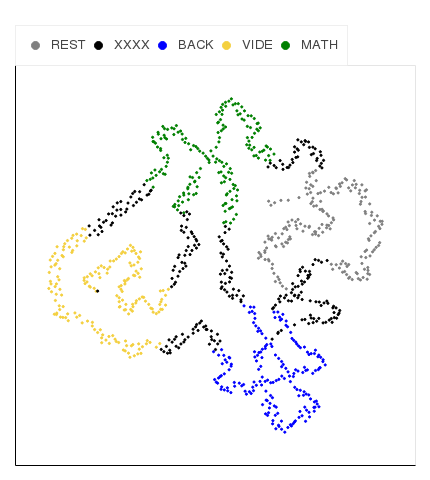

In [71]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add embedding_plot to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure05/ref2_umap_2demb.png")

Now, to get a better understanding of the optimization process, we will run the same call as above but using different number of epochs so that we can then look at the evolution of the embedding.

We will do this for two different values of the learning rate to see how an excessively high learning rate can lead to an unstable optimization.

> NOTE: The next cell takes a long time to run (approx. 30 mins)

In [73]:
%%time
optimization_E = {}                   # will hold all the embeddings for the different (learning_rate, num_epochs) combinations
optimization_diffs = {1.0:[],0.01:[]} # will hold the avg. euclidean distance between all samples at two consecutive optimization steps

for alpha_init in [1.0, 0.01]:
    for max_n_epochs in tqdm.tqdm_notebook(range(501)):
        # Compute the embedding for this particular case
        aux = umap.umap_.simplicial_set_embedding(data = tvFC.data, 
                                    graph = G, 
                                    n_components = 2,
                                    initial_alpha = alpha_init,
                                    a = mapper._a,
                                    b = mapper._b,
                                    gamma = mapper.repulsion_strength,
                                    negative_sample_rate = mapper.negative_sample_rate,
                                    n_epochs = max_n_epochs,
                                    init = 'spectral',
                                    random_state=check_random_state(20),
                                    metric=umap_metric_func,
                                    metric_kwds={},
                                    densmap = False,
                                    densmap_kwds= {'lambda': 0.0, 'frac': 0.0, 'var_shift': 0.1, 'n_neighbors': 90},
                                    output_dens=False,
                                    verbose=False,
                                    output_metric=umap_metric_func,
                                    output_metric_kwds={})[0]
        # Save the output into a pd.DataFrame object
        aux_df = pd.DataFrame(aux, columns=['orig_x','orig_y'])
        # Add two additional columns with positions after removing any mean (this will not change the embedding relations, but will allow the use of same limits for plotting)
        aux_df['xdm'] = aux_df['orig_x'] - aux_df['orig_x'].mean()
        aux_df['ydm'] = aux_df['orig_y'] - aux_df['orig_y'].mean()
        aux_df.index.name = 'Windows'
        # In some instances, embeddings at consecutive steps are very similar except for a vertical and/or horizontal flip. If that happens, we remove the flip and save
        # the correct layout (without flipping) as two extra columns ('x','y')
        if max_n_epochs > 0:
            # Gather the results from the previous epoch (after removing the mean)
            prev_e = optimization_E[(alpha_init,max_n_epochs-1)][['x','y']].copy()
            # Gather the embedding for the current epoch after demeaning
            asis   = aux_df[['xdm','ydm']].copy()
            asis.columns = ['x','y']
            # Flip the embedding for the current epoch along the X-axis
            flip_x = aux_df[['xdm','ydm']].copy()
            flip_x['xdm'] = -flip_x['xdm']
            flip_x.columns = ['x','y']
            # Flip the embedding for the current epoch along the Y-axis 
            flip_y = aux_df[['xdm','ydm']].copy()
            flip_y['ydm'] = -flip_y['ydm']
            flip_y.columns = ['x','y']
            # Flip the embedding for the current epoch along both axes
            flip_xy = -aux_df[['xdm','ydm']].copy()
            flip_xy.columns = ['x','y']
            # Compute the average sample-wise euclidean distance between locations in the previous epoch and all 4 potential solutions for
            # the current epoch
            d2_asis   = np.sqrt(np.square(prev_e-asis).sum(axis=1)).mean()
            d2_flipx  = np.sqrt(np.square(prev_e-flip_x).sum(axis=1)).mean()
            d2_flipy  = np.sqrt(np.square(prev_e-flip_y).sum(axis=1)).mean()
            d2_flipxy = np.sqrt(np.square(prev_e-flip_xy).sum(axis=1)).mean()
            # Put all distances in a single numpy array so we can detect which case is the one with the smallest distance
            diffs = np.array([d2_asis, d2_flipx, d2_flipy, d2_flipxy])
            i = np.argmin(diffs)
            optimization_diffs[alpha_init].append(np.min(diffs))
            # Add extra columns 'x' and 'y' with the correct embedding (that with the smallest distance to the previous epoch)
            if i == 0:
                aux_df['x'],aux_df['y']=asis['x'],asis['y']
            if i == 1:
                aux_df['x'],aux_df['y']=flip_x['x'],flip_x['y']
            if i == 2:
                aux_df['x'],aux_df['y']=flip_y['x'],flip_y['y']
            if i == 3:
                aux_df['x'],aux_df['y']=flip_xy['x'],flip_xy['y']
        else:
            # For the first epoch there is nothing to do regarding the flips, therefore the demeaned coordinates become columns 'x','y'
            aux_df['x'] = aux_df['xdm']
            aux_df['y'] = aux_df['ydm']
        # Add pd.DataFrame object to the optimization_path dictionary
        optimization_E[(alpha_init,max_n_epochs)] = aux_df
    

/data/SFIMJGC_HCP7T/Apps/envs/opentsne/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/501 [00:00<?, ?it/s]

/data/SFIMJGC_HCP7T/Apps/envs/opentsne/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/501 [00:00<?, ?it/s]

CPU times: user 1h 1min 15s, sys: 1h 1min 36s, total: 2h 2min 51s
Wall time: 37min 55s


To identify epoch in the optimization where the embeddings may have changed abruptly, we will plot the inter-epoch average distance. A high distance value signals a big change on the embedding from one epoch to the next. While this is expected at initial steps of the optimization process, the presence of many of those jumps later on might signal some issues with the optimization. In particuar it may signal that the selected learning rate is not appropriate for the problem at hand. 

We can see that happening for $\alpha_{init}=1.0$

The problem is not present when we use $\alpha_{init}=0.01$

In [83]:
aux = pd.DataFrame.from_dict(optimization_diffs)
aux.columns.name='Learning Rate'
aux.index.name = 'Epoch'
aux.index = aux.index + 1
optimization_plot = aux.hvplot(title='Inter-Epochs Difference', fontsize={'labels':14,'ticks':14}, ylabel='Avg. Euclidean Distance', xlabel='Epoch', legend='bottom_right', width=300, height=400, color=['gray','lightgray']).opts(legend_cols=3, toolbar=None)
pn.pane.HoloViews(optimization_plot).save('../Resources/Figure05/ref2_umap_2demb.png')

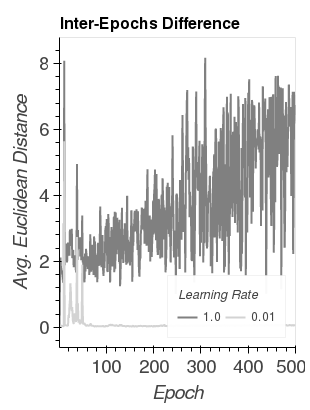

In [84]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add optimization_plot to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure05/ref2_umap_2demb.png")

To dynamically explore the evolution of the embeddings as the number of epochs increases, we create a small dashboard that looks the image below

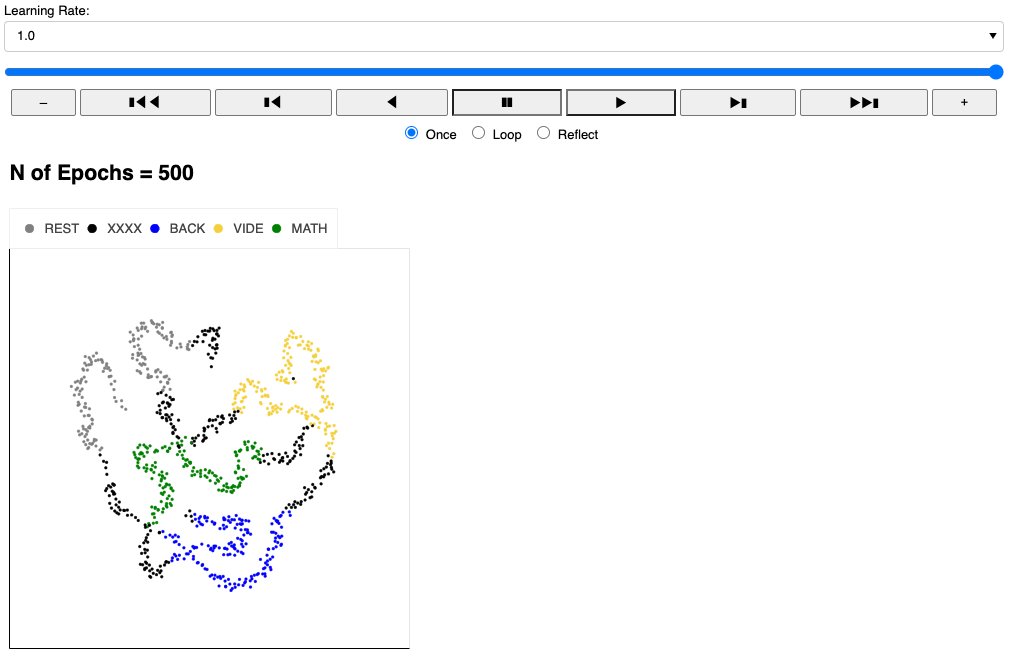

In [92]:
Image('../Resources/Figure05/UMAP_Dashboard.png')

This is the code that will create the dashboard in your local machine

In [85]:
gs_player = pn.widgets.Player(name='Gradient Descent', start=0, end=500, value=0, width=1000)
learning_rate_select = pn.widgets.Select(name='Learning Rate:', value=0.01, options=[0.01, 1.0])
@pn.depends(gs_player,learning_rate_select)
def plot_embed(gd_iter, alpha):
    df = pd.DataFrame.from_dict(optimization_E[(alpha,gd_iter)]).copy()
    df['Task'] = tvFC.labels
    return df.hvplot.scatter(x='x',y='y', aspect='square', cmap=cmap, size=5,
                             color='Task', xlabel='', 
                             ylabel='', title='N of Epochs = %d' % gd_iter, 
                             hover=False, xlim=(-12,12), ylim=(-12,12),
                             fontsize={'labels':14,'ticks':14,'title':16}, legend='top', frame_width=400).opts(xticks=[(-14,'')], yticks=[(-14,'')],toolbar=None)

In [86]:
dashboard = pn.Column(learning_rate_select,gs_player,plot_embed)

Run this code to start the dashbord

> NOTE: This code is designed to run on our HPC system. In there we have a environment variable ```PORT2``` with an avilable port number. You may want to change this to fit your system setup

In [88]:
import os
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

++ INFO: Second Port available: 34131


In [89]:
dashboard_server = dashboard.show(port=port_tunnel,open=False)

Launching server at http://localhost:34131


In [ ]:
dashboard_server.stop()

***

# APPENDIX. UMAP Supplementary Figure - Effect of min_dist

In [93]:
from tqdm.notebook import tqdm

In [115]:
results = {}
for min_dist in tqdm([0.1, 0.25, 0.40, 0.55, 0.70, 0.95]):
    aux = umap.UMAP(n_neighbors=knn, min_dist=min_dist,metric=d, 
                   random_state=random_state, 
                   verbose=True, 
                   learning_rate=alpha_init).fit(tvFC.data)
    # Save the output into a pd.DataFrame object
    aux_df = pd.DataFrame(aux.embedding_, columns=['orig_x','orig_y'])
    # Add two additional columns with positions after removing any mean (this will not change the embedding relations, but will allow the use of same limits for plotting)
    aux_df['xdm'] = aux_df['orig_x'] - aux_df['orig_x'].mean()
    aux_df['ydm'] = aux_df['orig_y'] - aux_df['orig_y'].mean()
    aux_df['Task'] = tvFC.labels
    aux_df.index.name = 'Windows'
    results[min_dist] = aux_df

  0%|          | 0/6 [00:00<?, ?it/s]

UMAP(learning_rate=0.01, n_neighbors=90, random_state=RandomState(MT19937) at 0x2AABECEAE6B0, verbose=True)
Fri Sep  2 09:55:38 2022 Construct fuzzy simplicial set
Fri Sep  2 09:55:42 2022 Finding Nearest Neighbors
Fri Sep  2 09:55:42 2022 Finished Nearest Neighbor Search
Fri Sep  2 09:55:42 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Sep  2 09:55:47 2022 Finished embedding
UMAP(learning_rate=0.01, min_dist=0.25, n_neighbors=90, random_state=RandomState(MT19937) at 0x2AABECEAE6B0, verbose=True)
Fri Sep  2 09:55:47 2022 Construct fuzzy simplicial set
Fri Sep  2 09:55:51 2022 Finding Nearest Neighbors
Fri Sep  2 09:55:51 2022 Finished Nearest Neighbor Search
Fri Sep  2 09:55:51 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Sep  2 09:55:55 2022 Finished embedding
UMAP(learning_rate=0.01, min_dist=0.4, n_neighbors=90, random_state=RandomState(MT19937) at 0x2AABECEAE6B0, verbose=True)
Fri Sep  2 09:55:55 2022 Construct fuzzy simplicial set
Fri Sep  2 09:55:59 2022 Finding Nearest Neighbors
Fri Sep  2 09:55:59 2022 Finished Nearest Neighbor Search
Fri Sep  2 09:55:59 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Sep  2 09:56:02 2022 Finished embedding
UMAP(learning_rate=0.01, min_dist=0.55, n_neighbors=90, random_state=RandomState(MT19937) at 0x2AABECEAE6B0, verbose=True)
Fri Sep  2 09:56:02 2022 Construct fuzzy simplicial set
Fri Sep  2 09:56:06 2022 Finding Nearest Neighbors
Fri Sep  2 09:56:06 2022 Finished Nearest Neighbor Search
Fri Sep  2 09:56:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Sep  2 09:56:10 2022 Finished embedding
UMAP(learning_rate=0.01, min_dist=0.7, n_neighbors=90, random_state=RandomState(MT19937) at 0x2AABECEAE6B0, verbose=True)
Fri Sep  2 09:56:10 2022 Construct fuzzy simplicial set
Fri Sep  2 09:56:14 2022 Finding Nearest Neighbors
Fri Sep  2 09:56:14 2022 Finished Nearest Neighbor Search
Fri Sep  2 09:56:14 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Sep  2 09:56:18 2022 Finished embedding
UMAP(learning_rate=0.01, min_dist=0.95, n_neighbors=90, random_state=RandomState(MT19937) at 0x2AABECEAE6B0, verbose=True)
Fri Sep  2 09:56:18 2022 Construct fuzzy simplicial set
Fri Sep  2 09:56:22 2022 Finding Nearest Neighbors
Fri Sep  2 09:56:22 2022 Finished Nearest Neighbor Search
Fri Sep  2 09:56:22 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Sep  2 09:56:27 2022 Finished embedding


In [129]:
layout = None
for min_dist in tqdm([0.1, 0.25, 0.40, 0.55, 0.70, 0.95]):
    if layout is None:
        layout = results[min_dist].hvplot.scatter(x='xdm',y='ydm', aspect='square', cmap=cmap, size=5,
                             color='Task', xlabel='', 
                             ylabel='', title='Min Dist = %0.2f'  % min_dist, 
                             hover=False, xlim=(-9,9), ylim=(-9,9),
                             fontsize={'labels':14,'ticks':14,'title':16}, legend='bottom_left', frame_width=400).opts(xticks=[(-14,'')], yticks=[(-14,'')],toolbar=None)
    else:
        layout = layout + results[min_dist].hvplot.scatter(x='xdm',y='ydm', aspect='square', cmap=cmap, size=5,
                             color='Task', xlabel='', 
                             ylabel='', title='Min Dist = %0.2f'  % min_dist, 
                             hover=False, xlim=(-9,9), ylim=(-9,9),
                             fontsize={'labels':14,'ticks':14,'title':16}, legend='bottom_left', frame_width=400).opts(xticks=[(-14,'')], yticks=[(-14,'')],toolbar=None)

  0%|          | 0/6 [00:00<?, ?it/s]

In [134]:
pn.pane.HoloViews(layout.cols(3).opts(toolbar=None)).save('../Resources/Figure05/UMAP_mindist_effects.png')

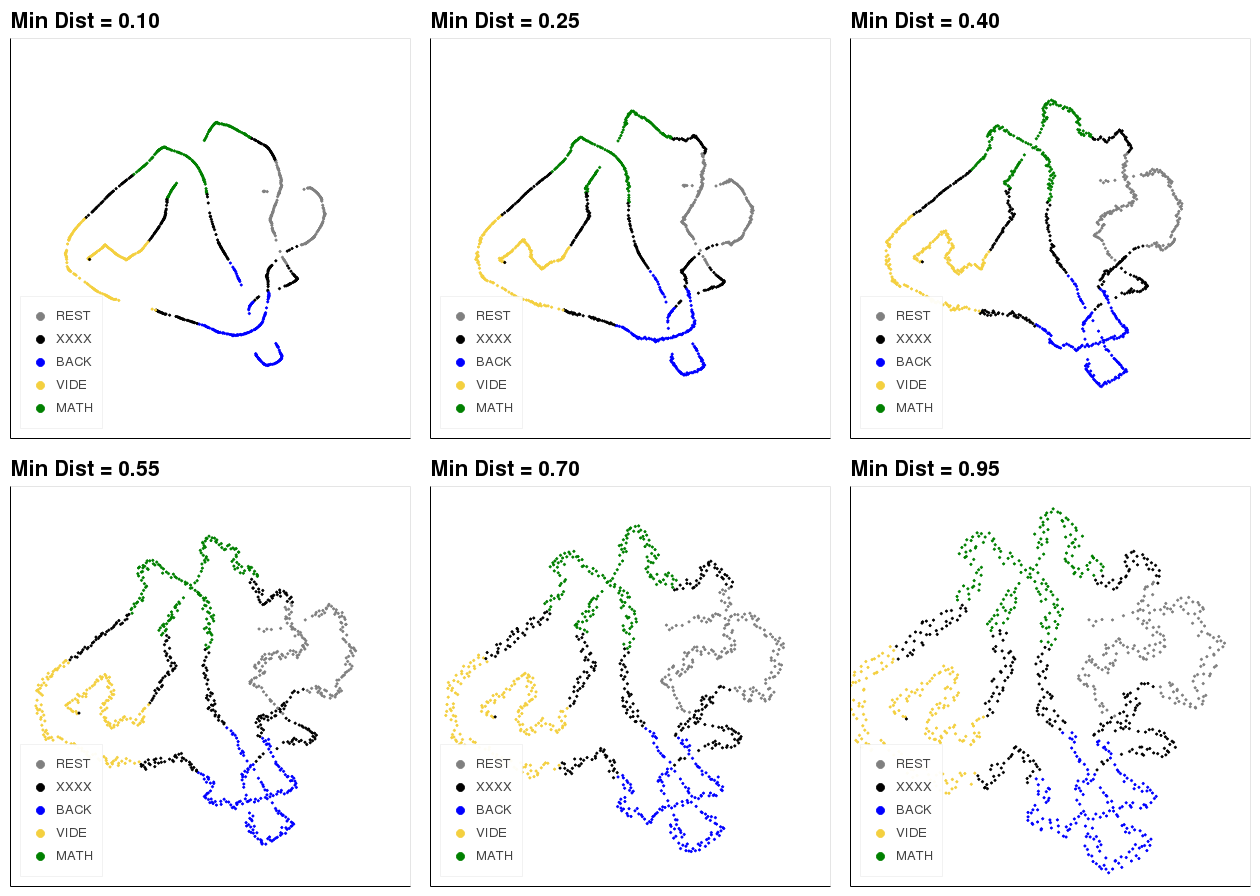

In [135]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add layout to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure05/UMAP_mindist_effects.png")

***

### Note on video creation

```bash
# Convert from .mov to .mp4
ffmpeg -i UMAP_Optimization_alpha0p01.mov -vcodec h264 -acodec mp2 UMAP_Optimization_alpha0p01.mp4
# Reduce video size
ffmpeg -i UMAP_Optimization_alpha0p01.mp4 -vcodec libx264 -crf 28 UMAP_Optimization_alpha0p01.small.mp4
```